# Add images, audio or video from URIs

In this "how-to" guide, we demonstrate how to add images, audio or video to SuperDuperDB.

First, let's get a `Datalayer` instance, in order to demonstrate:

In [2]:
import pymongo
from superduperdb import superduper
from superduperdb.db.mongodb.query import Collection

db = pymongo.MongoClient().documents

db = superduper(db)

collection = Collection('complexdata')

INFO:faiss.loader:Loading faiss.
INFO:faiss.loader:Successfully loaded faiss.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In order to encode, we create an `Encoder` instance:

In [4]:
from superduperdb.container.encoder import Encoder
import io
import pickle
import PIL.Image

# encoder handles conversion to `bytes`
def encoder(image):
    buf = io.BytesIO()
    image.save(buf, format='png')
    return buf.getvalue()

# decoder handles conversion from `bytes` to Python
decoder = lambda x: PIL.Image.open(io.BytesIO(x))

enc = Encoder(identifier='my-enc', encoder=encoder, decoder=decoder)

We don't need to load our objects (images etc.) to add to the DB, we can use URIs instead:

In [6]:
import glob
from superduperdb.container.document import Document as D

imgs = glob.glob('../img/*.png')

# wrap documents with `Document` in order so that SuperDuperDB knows how to handle
# wrap URI with `enc` to designate as "to-be-encoded"
# The URIs can be a mixture of `file://`, `http://`, `https://` and `s3://`
db.execute(
    collection.insert_many([
        D({'img': enc(uri=f'file://{img}')}) for img in imgs
    ], encoders=(enc,))
)

INFO:root:found 10 uris
INFO:botocore.credentials:Credentials found in config file: ~/.aws/config
INFO:root:number of workers 0
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 144.91it/s]


(<pymongo.results.InsertManyResult at 0x184531300>,
 TaskWorkflow(database=<superduperdb.db.base.db.DB object at 0x19c09cc90>, G=<networkx.classes.digraph.DiGraph object at 0x19c0ed910>))

In [7]:
r = db.execute(collection.find_one()).unpack()
r

{'_id': ObjectId('64ca089459670629027eac8f'),
 'img': <PIL.PngImagePlugin.PngImageFile image mode=RGBA size=120x120>,
 '_fold': 'train'}

We can verify that the image was properly stored:

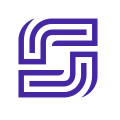

In [8]:
i = r['img'].convert('RGB')
i

We can also add Python objects directly:

In [9]:
db.execute(collection.insert_one(D({'img': enc(i), 'direct': True})))

INFO:root:found 0 uris


(<pymongo.results.InsertManyResult at 0x19c16fbe0>,
 TaskWorkflow(database=<superduperdb.db.base.db.DB object at 0x19c09cc90>, G=<networkx.classes.digraph.DiGraph object at 0x19d233a50>))

Verify:

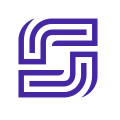

In [10]:
r = db.execute(collection.find_one({'direct': True})).unpack()
r['img']